## Corporate Individual Telco PortOut Predictive Model


**Definition of Corporate Individual : **
- An user ID, who registered under company name, but responsible for monthly phone credit payment

**Definition of PortOut:**
- Customer who changed to another mobile operator, but intend to retain his old number

**Definition of Target:** 
- 1 = PortOut customers
- 0 = Active customers

**Dependent Variables:**
1. 3 months aggregated usage (Voice call, Data, SMS)
2. Demographic Data
3. Account Detail

The objective of this model is to predict active Corporate Individual customers turn into PortOut customers. With PortOut predictive model, we can fight for retention with different types of campaigns and offers, before they portout.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_table('../Projects/CI portout Training Data Set/data2.txt',sep='|',na_values=' ')
df.drop(['SUBSCRIBER_ARRANGEMENT_ID','MOBILE_NO','START_DATE'], axis=1, inplace=True)
df.set_index('IDENTITY_NUMBER', inplace=True)
df.head()

,PAYMENT_METHOD,BILL_CYCLE,BILL_TYPE,PRODUCT_GROUP,DAYS_IN_STATUS_REASON,DEVICE_TYPE,STATE_C,REGION,AGE,GENDER,...,SUM_DATA_VOL_4G,SUM_AMT_PPU_REBATE,SUM_MOU_OUT_CALL,SUM_NUM_OUT_CALL,SUM_DATA_VOLUME,SUM_DURATION_DATA_VOL,SUM_DURATION_DATA_VOL_PPU,SUM_AMT_VOL_PURCHASE,SUM_NUM_VOL_PURCHASE,SUM_KB_VOL_PURCHASE
IDENTITY_NUMBER,,,,,,,,,,,,,,,,,,,,,
33857,CHEQUE,G28,ITEMISED,STAFF_DEALER,5445,SMART PHONE,PAHANG,EAST COAST REGION,64,MALE,...,0.0,0,450.83332,243,0.00,0,0,0,0,0
61486,CHEQUE,G18,PAPER,STAFF_DEALER,1225,SMART PHONE,SABAH,SABAH,68,MALE,...,0.0,0,0.00000,0,0.00,0,0,0,0,0
79290,CHEQUE,G08,PAPER,STAFF_DEALER,1225,SMART PHONE,PAHANG,EAST COAST REGION,56,MALE,...,0.0,0,39.78332,32,0.00,0,0,0,0,0
111224,CHEQUE,G18,PAPER,ENTERPRISE_LEGACY,946,BASIC PHONE,PAHANG,EAST COAST REGION,38,MALE,...,0.0,0,250.91671,131,0.00,0,0,0,0,0
129421,CHEQUE,G08,ITEMISED,RETAIL_CELCOM FIRST VOICE,566,SMART PHONE,KELANTAN,EAST COAST REGION,47,FEMALE,...,0.0,0,823.74971,775,4036083.67,0,0,0,0,0


In [3]:
## Removing rows with missing values

df.dropna(axis=0, how='any', inplace = True)

In [4]:
# Label Encoder for all Categorical Variable
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

df[['PAYMENT_METHOD','BILL_CYCLE','BILL_TYPE','PRODUCT_GROUP','DEVICE_TYPE','STATE_C','REGION','GENDER','NATIONALITY','PREFERRED_LANGUAGE','RACE']] =df[['PAYMENT_METHOD','BILL_CYCLE','BILL_TYPE','PRODUCT_GROUP','DEVICE_TYPE','STATE_C','REGION','GENDER','NATIONALITY','PREFERRED_LANGUAGE','RACE']].apply(enc.fit_transform)

In [5]:
# Define X and y

X = df.drop('FLAG_PORTOUT', axis=1)
y = df['FLAG_PORTOUT']

### Train Test Split
- Train set : 70%
- Test set : 30%

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

C:\Users\11771\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(271047, 128)
(116164, 128)
(271047,)
(116164,)


### Spliting Categorical and Numerical Variables for preprocessing purposes

In [15]:
X_train_cat = X_train[['PAYMENT_METHOD','BILL_CYCLE','BILL_TYPE','PRODUCT_GROUP','DEVICE_TYPE','STATE_C','REGION','GENDER','NATIONALITY','PREFERRED_LANGUAGE','RACE']] 
X_train_num = X_train.drop(['PAYMENT_METHOD','BILL_CYCLE','BILL_TYPE','PRODUCT_GROUP','DEVICE_TYPE','STATE_C','REGION','GENDER','NATIONALITY','PREFERRED_LANGUAGE','RACE'],axis=1)

### Feature Selection Stage 1:

- Reduce Variables with low variance (Threshold = 0.80)

In [8]:
from sklearn.feature_selection import VarianceThreshold

def VarianceThreshold_selector(data):
    columns = data.columns
    selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
    selector.fit_transform(data)
    labels = [columns[x] for x in selector.get_support(indices=True)]
    return pd.DataFrame(selector.fit_transform(data), columns=labels, index=data.index.values)

In [16]:
print("Number of categorical variables before remove low variance: " + str(X_train_cat.shape[1]))
X_train_cat = VarianceThreshold_selector(X_train_cat)
print("Number of categorical variables after remove low variance: " + str(X_train_cat.shape[1]))

Number of categorical variables before remove low variance: 11
Number of categorical variables after remove low variance: 9


In [17]:
print("Number of numerical variables before remove low variance: " + str(X_train_num.shape[1]))
X_train_num2 = VarianceThreshold_selector(X_train_num)
print("Number of numerical variables after remove low variance: " + str(X_train_num2.shape[1]))

Number of numerical variables before remove low variance: 117
Number of numerical variables after remove low variance: 105


### Preprocessing for Numerical Variables

1. Data Scaling
2. Outlier Treatment

In [25]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_num2)
X_train_num_scl = scaler.transform(X_train_num2)

X_train_num_scl = pd.DataFrame(X_train_num_scl, columns=X_train_num2.columns.values, index=list(X_train_num2.index.values))
X_train_num_scl.head()

,DAYS_IN_STATUS_REASON,AGE,TENURE_CAL,REC_IN_DAYS,REC_OUT_DAYS,AVG_DUR_TD,SUM_NUM_CALL_BAR,AVG_ACTIVE_DAY_R7,SUM_AMT_PPU,SUM_KB_PPU,...,SUM_NUM_IN_SMS_ONNET,SUM_NUM_IN_MMS,SUM_NUM_IN_VIDEO,SUM_DATA_VOL_2G,SUM_DATA_VOL_3G,SUM_DATA_VOL_4G,SUM_AMT_PPU_REBATE,SUM_MOU_OUT_CALL,SUM_NUM_OUT_CALL,SUM_DATA_VOLUME
87476,0.634540,0.178862,-0.461567,0.381746,-0.193082,-0.03625,-0.099445,-0.160373,-0.031956,-0.032980,...,-0.450457,-0.204932,-0.075572,-0.31557,-0.425631,-0.092921,0.026369,-0.364514,-0.144179,-0.440585
377962,0.569274,-1.119638,-0.915239,-0.244235,-0.018363,-0.03625,-0.099445,-2.475741,-0.031956,-0.032980,...,0.201640,-0.204932,-0.075572,-0.31557,-0.425631,-0.092921,0.026369,-0.578751,-0.775000,-0.440585
12777,-0.602740,-0.876169,-0.396756,-0.244235,1.029952,-0.03625,-0.099445,-1.212293,-0.028027,-0.029419,...,-0.067861,0.000419,-0.075572,-0.31557,-0.425631,-0.092724,0.026369,-0.549311,-0.683429,-0.440585
10507,-0.359728,-0.713857,1.239703,-0.244235,-0.367801,-0.03625,-0.099445,-0.531975,-0.031656,-0.032980,...,-0.440832,-0.204932,-0.075572,-0.31557,-0.425631,-0.089392,0.026369,-0.550015,-0.731758,-0.440585
101994,0.619265,-0.876169,-0.380554,-0.244235,-0.367801,-0.03625,-0.099445,0.445624,-0.031956,-0.032980,...,-0.310894,-0.204932,-0.075572,-0.31557,-0.425631,-0.092921,0.026369,-0.201425,-0.078045,-0.440585


In [26]:
# Outlier Treatment
data_Col = list(X_train_num_scl.columns.values)

for i in data_Col:
    low_mask= -3*X_train_num_scl[i].std() + X_train_num_scl[i].mean()
    high_mask= 3*X_train_num_scl[i].std() + X_train_num_scl[i].mean()
    X_train_num_scl[i] = round(X_train_num_scl[i].apply(lambda x: \
                        low_mask if x < low_mask else high_mask if x > high_mask else x),2)

In [140]:
X_train_num.describe()

,DAYS_IN_STATUS_REASON,AGE,TENURE_CAL,REC_IN_DAYS,REC_OUT_DAYS,AVG_DUR_TD,SUM_NUM_CALL_BAR,AVG_ACTIVE_DAY_R7,SUM_AMT_PPU,SUM_KB_PPU,...,SUM_DATA_VOL_4G,SUM_AMT_PPU_REBATE,SUM_MOU_OUT_CALL,SUM_NUM_OUT_CALL,SUM_DATA_VOLUME,SUM_DURATION_DATA_VOL,SUM_DURATION_DATA_VOL_PPU,SUM_AMT_VOL_PURCHASE,SUM_NUM_VOL_PURCHASE,SUM_KB_VOL_PURCHASE
count,271047.000000,271047.000000,271047.000000,271047.000000,271047.00000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,...,271047.000000,2.710470e+05,271047.000000,271047.000000,2.710470e+05,271047.0,271047.0,271047.0,271047.0,271047.0
mean,768.050091,43.796076,95.487262,1.780326,3.10510,0.150839,0.886555,5.033541,95.983353,1.018669,...,47.130679,-7.400517e+03,481.429437,307.682553,3.731362e+06,0.0,0.0,0.0,0.0,0.0
std,720.128988,12.321928,61.718733,3.194991,5.72348,4.161027,8.915026,1.922182,3003.621821,30.887453,...,507.212422,2.806499e+05,827.668188,393.139741,8.469114e+06,0.0,0.0,0.0,0.0,0.0
min,0.000000,-31.000000,5.000000,1.000000,1.00000,-2.725275,0.000000,0.000000,0.000000,0.000000,...,0.000000,-4.118982e+07,0.000000,0.000000,-6.745066e+06,0.0,0.0,0.0,0.0,0.0
25%,343.000000,35.000000,53.000000,1.000000,1.00000,0.000000,0.000000,3.868132,0.000000,0.000000,...,0.000000,0.000000e+00,86.508325,77.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0
50%,631.000000,43.000000,76.000000,1.000000,1.00000,0.000000,0.000000,5.758242,0.000000,0.000000,...,0.000000,0.000000e+00,239.766650,187.000000,2.000000e-02,0.0,0.0,0.0,0.0,0.0
75%,1225.000000,52.000000,138.000000,1.000000,2.00000,0.000000,0.000000,6.615385,0.000000,0.000000,...,0.000000,0.000000e+00,554.875075,388.000000,3.516145e+06,0.0,0.0,0.0,0.0,0.0
max,8178.000000,1948.000000,273.000000,41.000000,41.00000,188.087912,182.000000,7.000000,441332.500000,4309.880000,...,74377.530000,0.000000e+00,82977.495510,13118.000000,1.975808e+08,0.0,0.0,0.0,0.0,0.0


In [139]:
X_train_num_scl.describe()

,AGE,TENURE_CAL,REC_IN_DAYS,REC_OUT_DAYS,SUM_NUM_CALL_BAR,AVG_ACTIVE_DAY_R7,SUM_AMT_OUT_CALL_ONNET,SUM_AMT_OUT_CALL_OFFNET,SUM_AMT_OUT_CALL_DIGI,SUM_AMT_OUT_CALL_MAXIS,...,SUM_NUM_OUT_CALL_NADJ,SUM_NUM_OUT_CALL_ADJ,SUM_MOU_IN_CALL_DOMESTIC,SUM_MOU_IN_CALL_FIXED,SUM_NUM_IN_CALL_OFFNET,SUM_NUM_IN_CALL_FIXED,SUM_NUM_IN_SMS_OFFNET,SUM_NUM_IN_SMS_ONNET,SUM_DATA_VOL_3G,SUM_DATA_VOL_4G
count,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,...,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000,271047.000000
mean,0.000774,0.000021,-0.056233,-0.052983,-0.067932,-0.000794,-0.038480,-0.025424,-0.037058,-0.023645,...,-0.046038,-0.037595,-0.032617,-0.036944,-0.036051,-0.037922,-0.016005,-0.029692,-0.042462,-0.043686
std,0.931624,1.000118,0.573274,0.753364,0.311317,0.999567,0.713903,0.459097,0.544363,0.543954,...,0.617889,0.764092,0.753026,0.691406,0.767141,0.687482,0.225570,0.503177,0.782366,0.353356
min,-3.000000,-1.470000,-0.240000,-0.370000,-0.100000,-2.620000,-0.440000,-0.260000,-0.260000,-0.290000,...,-0.320000,-0.570000,-0.680000,-0.480000,-0.660000,-0.520000,-0.120000,-0.530000,-1.550000,-0.090000
25%,-0.710000,-0.690000,-0.240000,-0.370000,-0.100000,-0.610000,-0.440000,-0.260000,-0.260000,-0.290000,...,-0.320000,-0.530000,-0.530000,-0.460000,-0.530000,-0.450000,-0.100000,-0.350000,-0.430000,-0.090000
50%,-0.060000,-0.320000,-0.240000,-0.370000,-0.100000,0.380000,-0.380000,-0.200000,-0.260000,-0.270000,...,-0.300000,-0.340000,-0.290000,-0.320000,-0.310000,-0.280000,-0.080000,-0.170000,-0.430000,-0.090000
75%,0.670000,0.690000,-0.240000,-0.190000,-0.100000,0.820000,0.040000,0.000000,-0.100000,-0.010000,...,-0.100000,0.100000,0.160000,0.070000,0.140000,0.060000,-0.010000,0.130000,-0.050000,-0.090000
max,3.000000,2.880000,3.000000,3.000000,3.000000,1.020000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


### Feature Selection Stage 2:

- Using Hypothesis Testing to remove insigificant mean between 0 and 1
    -  For <font color=blue>categorical variables</font>, **Chi-Squared Test** is used for hypothesis testing.
    -  For <font color=blue>numerical variables</font>, **t-test** is used for hypothesis testing.
<br>    
- Remove Multicollinearity 

In [20]:
# Chi Square Test
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

cat_col_name = list(X_train_cat.columns)

for i in cat_col_name:
    a = pd.crosstab(X_train_cat[i],y_train)
    #print("p-value of {}: {:.3f}".format(i, chi2_contingency(a)[1]))
    if chi2_contingency(a)[1] > 0.05 :
        print("p-value of {}: {:.3f}".format(i, chi2_contingency(a)[1]))
        X_train_cat.drop([i],axis=1,inplace=True)

p-value of BILL_CYCLE: 0.308
p-value of GENDER: 0.361


In [27]:
# t-Test
# If the p-value is less than 0.05, we reject the null hypothesis

from scipy.stats import ttest_ind

num_col_name = list(X_train_num_scl.columns)

print("Drop Variables:")
print("")

for i in num_col_name:
    a = pd.concat([X_train_num_scl[i],y_train],axis=1)
    F0 = a[a['FLAG_PORTOUT']==0]
    F1 = a[a['FLAG_PORTOUT']==1]
    
    if ttest_ind(F0[i], F1[i]).pvalue > 0.05 :
        print(i)
        X_train_num_scl.drop([i],axis=1,inplace=True)

Drop Variables:

DAYS_IN_STATUS_REASON
AVG_DUR_TD
SUM_AMT_PPU
SUM_KB_PPU
SUM_AMT_OUT_CALL_SPECIAL
SUM_AMT_OUT_CALL_CUG
SUM_AMT_OUT_CALL_IDD
SUM_AMT_OUT_CALL_VIDEO
SUM_AMT_OUT_MMS
SUM_AMT_OUT_SMS
SUM_AMT_OUT_SMS_ONNET
SUM_AMT_OUT_SMS_CUG
SUM_AMT_OUT_SMS_INTL
SUM_MOU_OUT_CALL_ONNET
SUM_MOU_OUT_CALL_OFFNET
SUM_MOU_OUT_CALL_DOMESTIC
SUM_MOU_OUT_CALL_FIXED
SUM_MOU_OUT_CALL_DIGI
SUM_MOU_OUT_CALL_MAXIS
SUM_MOU_OUT_CALL_FREE
SUM_NUM_OUT_CALL_ONNET
SUM_NUM_OUT_CALL_OFFNET
SUM_NUM_OUT_CALL_DIGI
SUM_NUM_OUT_CALL_MAXIS
SUM_NUM_OUT_CALL_DOMESTIC
SUM_NUM_OUT_CALL_FIXED
SUM_NUM_OUT_MMS_FREE
SUM_NUM_OUT_CALL_ROAM_HOME
SUM_NUM_OUT_CALL_ROAM_LOCAL
SUM_NUM_OUT_CALL_LESS_X_MIN_1
SUM_NUM_OUT_CALL_LESS_X_MIN_2
SUM_NUM_OUT_CALL_LESS_X_MIN_3
SUM_NUM_OUT_CALL_LESS_X_MIN_4
SUM_NUM_OUT_CALL_LESS_X_MIN_5
SUM_NUM_OUT_CALL_LESS_X_MIN_6
SUM_NUM_OUT_CALL_LESS_X_MIN_7
SUM_NUM_OUT_CALL_LESS_X_MIN_8
SUM_NUM_OUT_CALL_LESS_X_MIN_9
SUM_NUM_OUT_CALL_LESS_X_MIN_10
SUM_NUM_OUT_MMS
SUM_NUM_OUT_SMS
SUM_NUM_OUT_SMS_ONNET
SUM_NUM

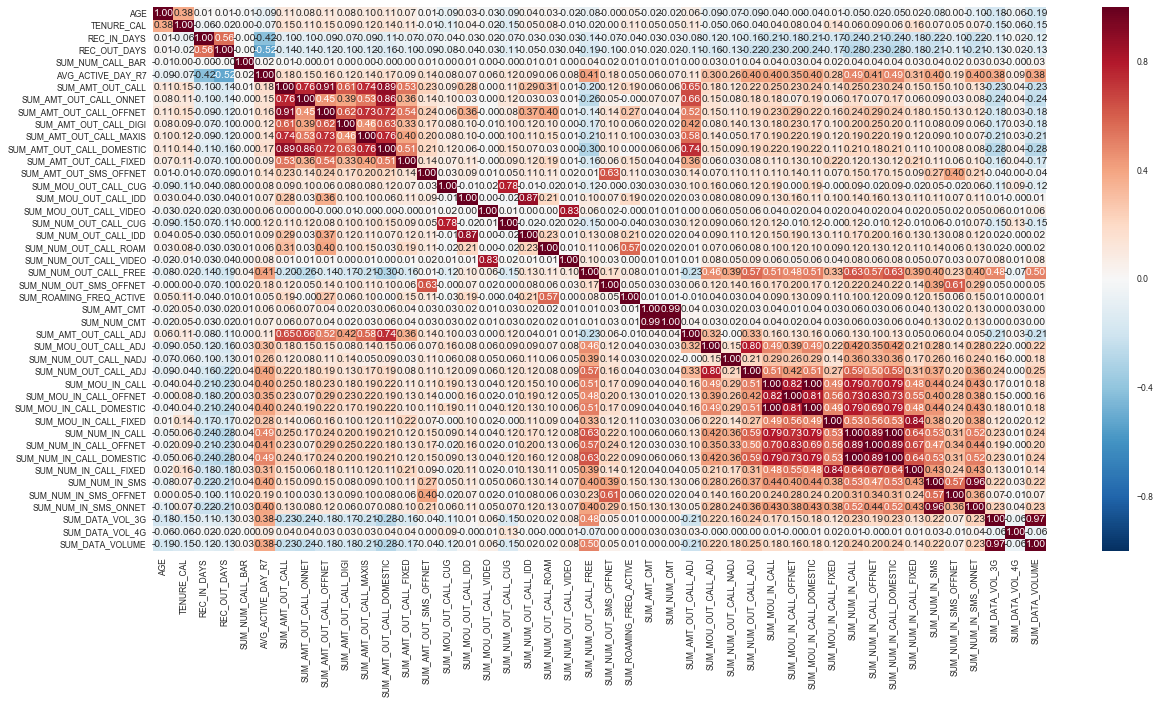

In [28]:
# Multicollinearity

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=0.85)
plt.figure(figsize=(20,10))
sns.heatmap(X_train_num_scl[list(X_train_num_scl.columns)].corr(),annot=True,fmt=".2f")
plt.show()

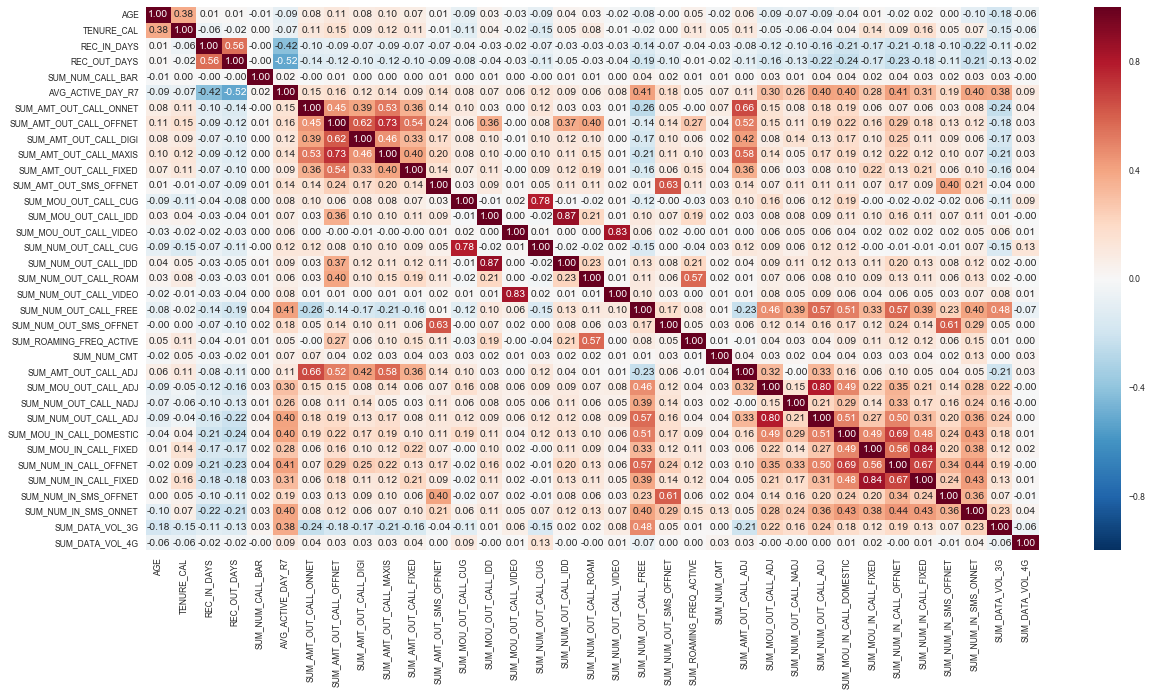

In [29]:
# After Removing Variables with High VIF 
X_train_num_scl.drop(['SUM_NUM_IN_CALL','SUM_MOU_IN_CALL', 'SUM_AMT_OUT_CALL', 'SUM_AMT_CMT', 'SUM_DATA_VOLUME','SUM_AMT_OUT_CALL_DOMESTIC', 'SUM_NUM_IN_CALL_DOMESTIC', 'SUM_NUM_IN_SMS','SUM_MOU_IN_CALL_OFFNET'], axis=1, inplace=True)

plt.figure(figsize=(20,10))
sns.heatmap(X_train_num_scl[list(X_train_num_scl.columns)].corr(),annot=True,fmt=".2f")
plt.show()

### Combine Categorical and Numerical Variables

In [30]:
X_train0 = pd.concat([X_train_num_scl,X_train_cat],axis=1)
X_train0.head()

,AGE,TENURE_CAL,REC_IN_DAYS,REC_OUT_DAYS,SUM_NUM_CALL_BAR,AVG_ACTIVE_DAY_R7,SUM_AMT_OUT_CALL_ONNET,SUM_AMT_OUT_CALL_OFFNET,SUM_AMT_OUT_CALL_DIGI,SUM_AMT_OUT_CALL_MAXIS,...,SUM_NUM_IN_SMS_ONNET,SUM_DATA_VOL_3G,SUM_DATA_VOL_4G,BILL_TYPE,PRODUCT_GROUP,DEVICE_TYPE,STATE_C,REGION,PREFERRED_LANGUAGE,RACE
87476,0.18,-0.46,0.38,-0.19,-0.1,-0.16,-0.38,0.08,-0.15,0.08,...,-0.45,-0.43,-0.09,3,3,0,2,1,0,2
377962,-1.12,-0.92,-0.24,-0.02,-0.1,-2.48,-0.44,-0.26,-0.26,-0.29,...,0.20,-0.43,-0.09,5,3,4,0,5,4,0
12777,-0.88,-0.40,-0.24,1.03,-0.1,-1.21,-0.44,-0.24,-0.24,-0.26,...,-0.07,-0.43,-0.09,5,3,4,8,2,2,2
10507,-0.71,1.24,-0.24,-0.37,-0.1,-0.53,-0.33,-0.25,-0.26,-0.29,...,-0.44,-0.43,-0.09,4,13,4,3,0,0,2
101994,-0.88,-0.38,-0.24,-0.37,-0.1,0.45,-0.36,0.49,0.20,0.77,...,-0.31,-0.43,-0.09,5,3,4,0,5,2,0


### Data Resampling

In [34]:
# Count of 0 and 1
np.bincount(y_train.values)

array([268926,   2121], dtype=int64)

In [37]:
# Percentage of majority and minority
print("% of majority (0): " + str(round(268926/(268926+2121)*100,2)))
print("% of minority (1): " + str(round(2121/(268926+2121)*100,2)))

% of majority (0): 99.22
% of minority (1): 0.78


In [38]:
data = pd.concat([X_train0,y_train],axis=1)

from sklearn.utils import resample

# Separate majority and minority classes
data_majority = data[data.FLAG_PORTOUT==0]
data_minority = data[data.FLAG_PORTOUT==1]
 
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6363,    # to match majority class
                                 random_state=123) # reproducible results

# Downsample majority class
data_majority_downsampled = resample(data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=14847,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
data_resample = pd.concat([data_majority_downsampled, data_minority_upsampled])
 
# Display new class counts
data_resample.FLAG_PORTOUT.value_counts()

0    14847
1     6363
Name: FLAG_PORTOUT, dtype: int64

In [40]:
# Percentage of majority and minority after resampling
print("% of majority (0): " + str(round(14847/(14847+6363)*100,2)))
print("% of minority (1): " + str(round(6363/(14847+6363)*100,2)))

% of majority (0): 70.0
% of minority (1): 30.0


In [41]:
# Split X and y
X_train0 = data_resample.drop('FLAG_PORTOUT', axis=1)
y_res = data_resample['FLAG_PORTOUT']

### Dimensional Reduction using PCA

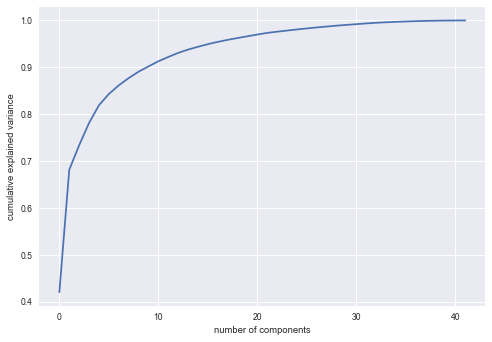

In [45]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train0)

##plt.plot(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [46]:
pca = PCA(n_components=10, random_state=0)
pca.fit(X_train0)

X_pca = pca.transform(X_train0)

#### Distribution of PCA

In [151]:
X_pca_df = pd.DataFrame(X_pca, columns=['PCA 0','PCA 1','PCA 2','PCA 3','PCA 4','PCA 5','PCA 6','PCA 7','PCA 8','PCA 9'])

pca_df = pd.concat([X_pca_df,pd.DataFrame(y_res,columns=['FLAG_PORTOUT']).reset_index()],axis=1)
pca_df.head()

,PCA 0,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,IDENTITY_NUMBER,FLAG_PORTOUT
0,5.110342,5.452761,3.366157,0.857842,-0.567237,-0.044769,0.060976,-0.600802,0.566321,0.395484,219661,0
1,6.023343,-2.295797,-2.965220,0.552434,-1.095158,-1.512114,0.468204,0.774284,0.010783,1.118899,33770,0
2,0.892902,-2.492928,1.156599,-1.217535,0.616962,1.208851,0.847290,-1.264697,-1.745864,-0.081307,340568,0
3,-8.437020,-1.910568,0.094111,1.441596,3.398161,-0.325774,-0.094912,-0.823700,-0.644146,-0.997197,173108,0
4,6.128625,-1.328752,-0.914532,-0.182077,-3.987522,-0.052664,0.889926,1.167447,-0.214906,0.650730,146704,0


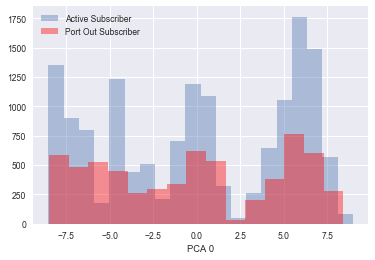

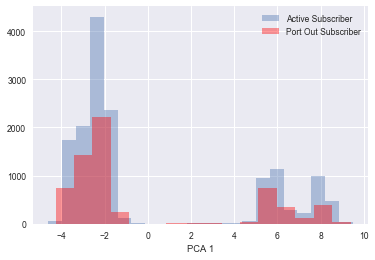

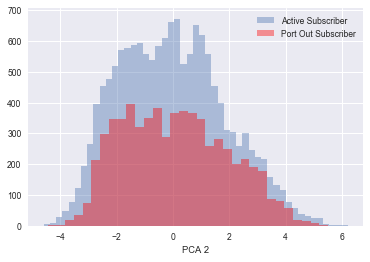

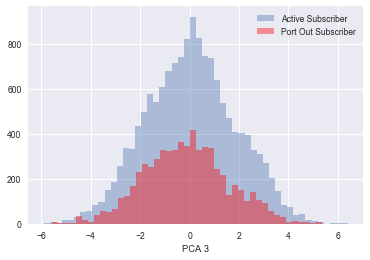

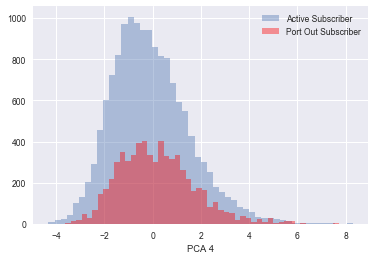

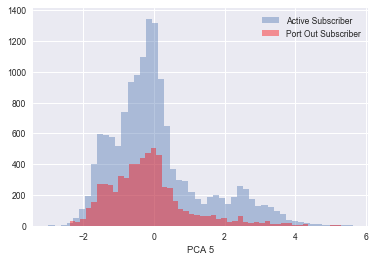

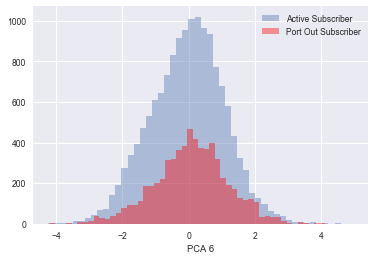

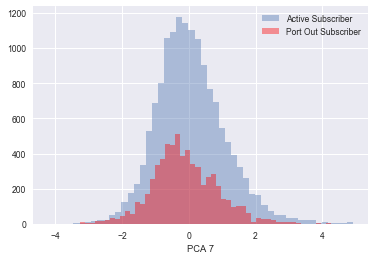

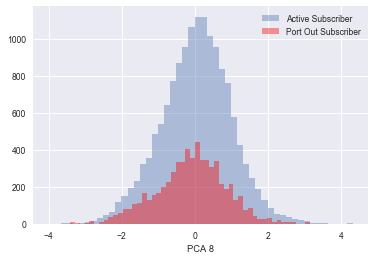

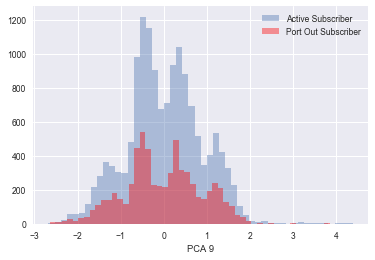

In [153]:
col = ['PCA 0','PCA 1','PCA 2','PCA 3','PCA 4','PCA 5','PCA 6','PCA 7','PCA 8','PCA 9']

for i in col:
    sns.distplot(pca_df[pca_df.FLAG_PORTOUT == 0][i], kde=False, label='Active Subscriber')
    sns.distplot(pca_df[pca_df.FLAG_PORTOUT == 1][i], kde=False, color='red', label='Port Out Subscriber')
    plt.legend()
    plt.show();

## Preparing for Test Dataset 
### Split Categorical and Numerical Variables

In [62]:
X_test_cat = X_test[['PAYMENT_METHOD','BILL_CYCLE','BILL_TYPE','PRODUCT_GROUP','DEVICE_TYPE','STATE_C','REGION','GENDER','NATIONALITY','PREFERRED_LANGUAGE','RACE']] 
X_test_num = X_test.drop(['PAYMENT_METHOD','BILL_CYCLE','BILL_TYPE','PRODUCT_GROUP','DEVICE_TYPE','STATE_C','REGION','GENDER','NATIONALITY','PREFERRED_LANGUAGE','RACE'],axis=1)

### Categorical Variables

In [65]:
X_test_cat = X_test_cat[list(X_train_cat.columns)]

### Numerical Variables

In [66]:
# Standard Scaler
X_test_num = X_test_num[list(X_train_num2.columns)]
X_test_num_scl = scaler.transform(X_test_num)
X_test_num_scl = pd.DataFrame(X_test_num_scl, columns=X_test_num.columns.values, index=list(X_test_num.index.values))

# Outlier Treatment
data_Col3 = list(X_test_num_scl.columns.values)
for i in data_Col3:
    low_mask= -3*X_test_num_scl[i].std() + X_test_num_scl[i].mean()
    high_mask= 3*X_test_num_scl[i].std() + X_test_num_scl[i].mean()
    X_test_num_scl[i] = round(X_test_num_scl[i].apply(lambda x: \
                        low_mask if x < low_mask else high_mask if x > high_mask else x),2)

X_test_num_scl = X_test_num_scl[list(X_train_num_scl.columns)]

### Combine Categorical and Numerical Variables

In [67]:
X_test0 = pd.concat([X_test_num_scl,X_test_cat],axis=1)

X_pca_test = pca.transform(X_test0)

## Algorithm Used:
1. Extra Tree Classifier
2. Random Forest
3. k-Nearest Neighbors with bagging

<br>Train set : X_pca, y_res
<br>Test set : X_pca_test, y_test

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Extra Tree Classifier & Random Forest
#### Grid Search

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(class_weight="balanced")
param__grid = [{'n_estimators': [10, 50, 100, 500, 1000],
                'max_depth' : [4,5,6,7,8,9,10],
                'bootstrap': [True,False]}]

grid_rf = GridSearchCV(clf, param__grid)
grid_rf.fit(X_pca, y_res)

GridSearchCV(cv=None, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 50, 100, 500, 1000], 'max_depth': [4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
print(grid_rf.best_estimator_.n_estimators)
print(grid_rf.best_estimator_.max_depth)
print(grid_rf.best_estimator_.bootstrap)

500
10
True


#### Cross Validation

In [63]:
from sklearn.model_selection import cross_val_score

depth = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    
# empty list that will hold cv scores
exc_cv_scores = []

# perform 10-fold cross validation
for d in depth:
    exc_cv = ExtraTreesClassifier(n_estimators=500, max_depth=d, class_weight="balanced")
    scores = cross_val_score(exc_cv, X_pca, y_res, cv=10)
    exc_cv_scores.append(scores.mean())

The optimal number of depth is 30


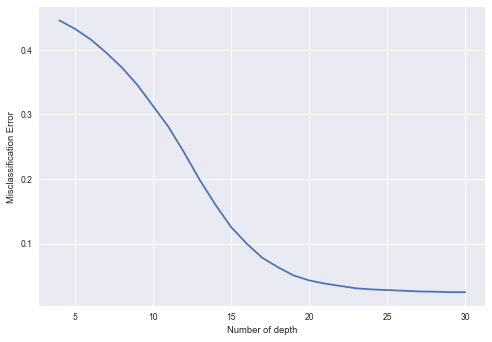

In [64]:
# changing to misclassification error
MSE = [1 - x for x in exc_cv_scores]

# determining best depth
optimal_depth = depth[MSE.index(min(MSE))]
print ("The optimal number of depth is %d" % optimal_depth)

# plot misclassification error vs depth
plt.plot(depth, MSE)
plt.xlabel('Number of depth')
plt.ylabel('Misclassification Error')
plt.show()

#### Extra Tree Classifier

Train Score: 0.72
Accuracy: 0.72
roc auc score: 0.86

             precision    recall  f1-score   support

          0       0.91      0.67      0.77     14847
          1       0.52      0.85      0.65      6363

avg / total       0.80      0.72      0.74     21210



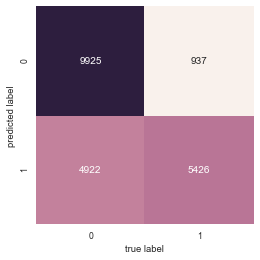

ROC Curve
AUROC Score: 0.862527530933


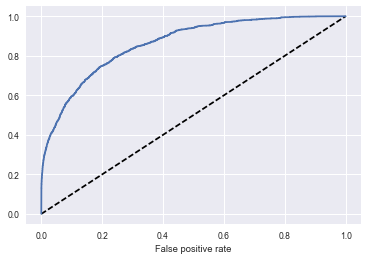

In [73]:
exc = ExtraTreesClassifier(n_estimators=500, max_depth=10, bootstrap=True, class_weight="balanced")

exc = exc.fit(X_pca, y_res)

y_pred_train_exc = exc.predict(X_pca)

print('Train Score: {:.2f}'.format(exc.score(X_pca, y_res)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_res,y_pred_train_exc)))
print('roc auc score: {:.2f}'.format(roc_auc_score(y_res,exc.predict_proba(X_pca)[:,1])))
print('')
print(classification_report(y_res,y_pred_train_exc))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_res,y_pred_train_exc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_res, exc.predict_proba(X_pca)[:,1], pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_res, exc.predict_proba(X_pca)[:,1]))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')

Test Score: 0.64
Accuracy: 0.64
roc auc score: 0.63

             precision    recall  f1-score   support

          0       0.99      0.64      0.78    115239
          1       0.01      0.54      0.02       925

avg / total       0.99      0.64      0.77    116164



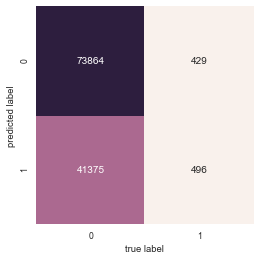

ROC Curve
AUROC Score: 0.625668890717


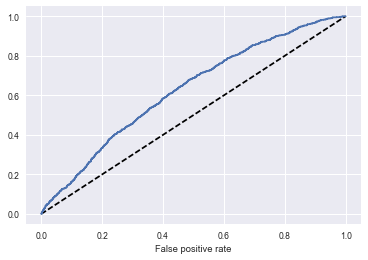

In [74]:
y_pred_exc = exc.predict(X_pca_test)

print('Test Score: {:.2f}'.format(exc.score(X_pca_test,y_test)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,y_pred_exc)))
print('roc auc score: {:.2f}'.format(roc_auc_score(y_test,exc.predict_proba(X_pca_test)[:,1])))
print('')
print(classification_report(y_test,y_pred_exc))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test,y_pred_exc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, exc.predict_proba(X_pca_test)[:,1], pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_test, exc.predict_proba(X_pca_test)[:,1]))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')

#### Random Forest

Train Score: 0.72
Accuracy: 0.85
roc auc score: 0.96

             precision    recall  f1-score   support

          0       0.98      0.81      0.88     14847
          1       0.68      0.96      0.79      6363

avg / total       0.89      0.85      0.86     21210



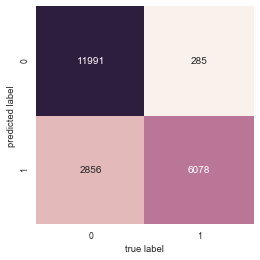

ROC Curve
AUROC Score: 0.960574294495


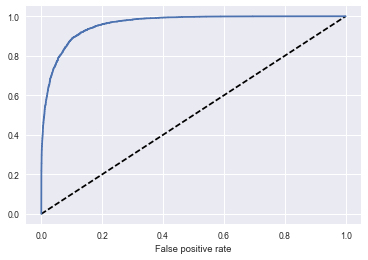

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, max_depth=10, bootstrap=True, class_weight="balanced")

rf = rf.fit(X_pca, y_res)

y_pred_train_rf = rf.predict(X_pca)

print('Train Score: {:.2f}'.format(exc.score(X_pca, y_res)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_res,y_pred_train_rf)))
print('roc auc score: {:.2f}'.format(roc_auc_score(y_res,rf.predict_proba(X_pca)[:,1])))
print('')
print(classification_report(y_res,y_pred_train_rf))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_res,y_pred_train_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_res, rf.predict_proba(X_pca)[:,1], pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_res, rf.predict_proba(X_pca)[:,1]))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')

Test Score: 0.64
Accuracy: 0.76
roc auc score: 0.63

             precision    recall  f1-score   support

          0       0.99      0.76      0.86    115239
          1       0.01      0.38      0.02       925

avg / total       0.99      0.76      0.85    116164



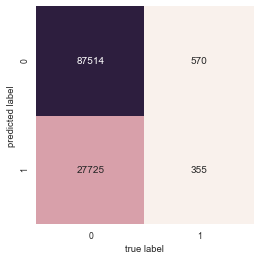

ROC Curve
AUROC Score: 0.63057201684


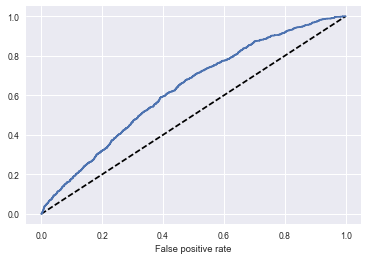

In [78]:
y_pred_rf = rf.predict(X_pca_test)

print('Test Score: {:.2f}'.format(exc.score(X_pca_test,y_test)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,y_pred_rf)))
print('roc auc score: {:.2f}'.format(roc_auc_score(y_test,rf.predict_proba(X_pca_test)[:,1])))
print('')
print(classification_report(y_test,y_pred_rf))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_pca_test)[:,1], pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_test, rf.predict_proba(X_pca_test)[:,1]))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')

### k-Nearest Neighbors
#### Grid Search

In [79]:
# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param__grid = [{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                'weights' : ['uniform','distance']}]

grid_knn = GridSearchCV(knn, param__grid)
grid_knn.fit(X_pca, y_res)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [80]:
print(grid_knn.best_score_)
print(grid_knn.best_estimator_.n_neighbors)
print(grid_knn.best_estimator_.weights)

0.865865157944
1
uniform


#### Cross Validation

In [81]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))
    
# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_pca, y_res, cv=10)
    cv_scores.append(scores.mean())

The optimal number of neighbors is 1


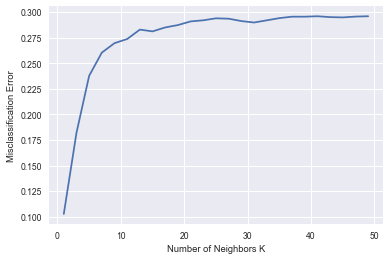

In [82]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

#### k-Nearest Neighbors

Train Score: 0.73
Accuracy: 0.73
roc auc score: 0.75

             precision    recall  f1-score   support

          0       0.75      0.92      0.83     14847
          1       0.61      0.28      0.38      6363

avg / total       0.71      0.73      0.69     21210



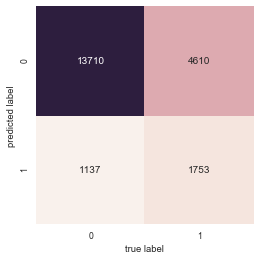

ROC Curve
AUROC Score: 0.750478935644


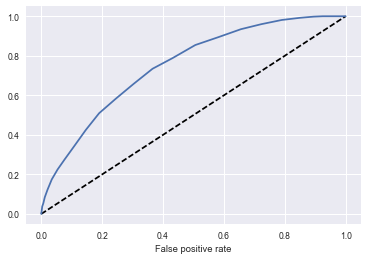

In [88]:
knn = KNeighborsClassifier(n_neighbors=30)

knn = knn.fit(X_pca, y_res)

y_pred_train_knn = knn.predict(X_pca)

print('Train Score: {:.2f}'.format(knn.score(X_pca, y_res)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_res,y_pred_train_knn)))
print('roc auc score: {:.2f}'.format(roc_auc_score(y_res,knn.predict_proba(X_pca)[:,1])))
print('')
print(classification_report(y_res,y_pred_train_knn))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_res,y_pred_train_knn)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_res, knn.predict_proba(X_pca)[:,1], pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_res, knn.predict_proba(X_pca)[:,1]))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')
plt.xlabel('False positive rate')

Test Score: 0.64
Accuracy: 0.91
roc auc score: 0.59

             precision    recall  f1-score   support

          0       0.99      0.91      0.95    115239
          1       0.01      0.14      0.02       925

avg / total       0.98      0.91      0.94    116164



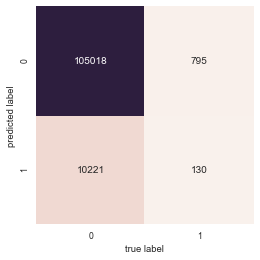

ROC Curve
AUROC Score: 0.585106707728


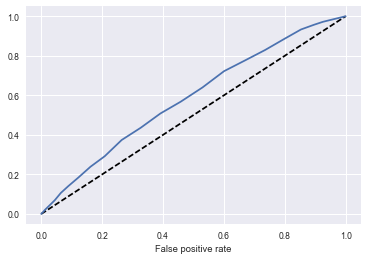

In [89]:
y_pred_knn = knn.predict(X_pca_test)

print('Test Score: {:.2f}'.format(exc.score(X_pca_test,y_test)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,y_pred_knn)))
print('roc auc score: {:.2f}'.format(roc_auc_score(y_test,knn.predict_proba(X_pca_test)[:,1])))
print('')
print(classification_report(y_test,y_pred_knn))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test,y_pred_knn)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_pca_test)[:,1], pos_label=1)
auc_result = auc(fpr, tpr)
print('ROC Curve')
print('AUROC Score:',roc_auc_score(y_test, knn.predict_proba(X_pca_test)[:,1]))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
plt.xlabel('False positive rate')

### Final Model
#### Random Forest

In [148]:
indices

array([5, 4, 3, 8, 1, 2, 7, 0, 6, 9], dtype=int64)

Feature ranking:
1. feature 5 (0.121522)
2. feature 4 (0.116811)
3. feature 3 (0.104460)
4. feature 8 (0.100688)
5. feature 1 (0.098888)
6. feature 2 (0.097551)
7. feature 7 (0.097481)
8. feature 0 (0.093109)
9. feature 6 (0.086412)
10. feature 9 (0.083078)


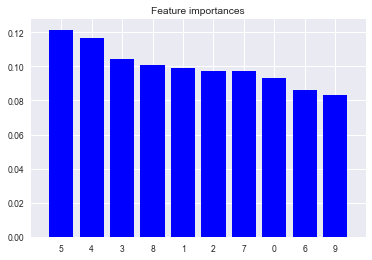

In [150]:
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_pca.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_pca.shape[1]), importances[indices],
       color="blue", yerr=std[indices], align="center")
plt.xticks(range(X_pca.shape[1]), indices)
plt.xlim([-1, X_pca.shape[1]])
plt.show()